In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy
from scipy.stats.stats import _attempt_exact_2kssamp, _compute_prob_outside_square, distributions
from math import gcd
import os, sys
import warnings

In [2]:
def imp_sample(rho_array, rho_obs):
    '''
    Perform standard importance sampling from rho_tilde --> {e, omega}
    
    Args:
    rho_array [array]: sampled data for pseudo-density rho_tilde
    rho_obs [tuple]: values of the true stellar density and its uncertainty
    
    Output:
    weights [array]: importance sampling weights
    ecc [array]: random values drawn uniformly from 0 to 1, with array length = len(rho_array)
    omega [array]:random values drawn uniformly from -pi/2 to 3pi/2, with array length = len(rho_array)
    '''
    
    ecc = np.random.uniform(0., 1., len(rho_array))
    omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(rho_array))

    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_array / g ** 3

    log_weight = -0.5 * ((rho - rho_obs[0]) / rho_obs[1]) ** 2
    weight_rho = np.exp(log_weight - np.max(log_weight))
    weight_rho /= np.sum(weight_rho)

    weights = np.array(weight_rho/np.sum(weight_rho))
    
    return weights, ecc, omega


def check_weights(w, n, idx):
    '''
    Check for weights; if None, then give uniform weights
    
    Args:
    w [array or None]: weights of data or None
    n [int]: length of data that will be weighted
    idx [array]: sorted index values of data
    
    Output:
    output:
    w_out [array]: numerical weights from input OR uniform weights if 'w' == None
    '''
    if w is None: 
        w_out = np.full(n, 1/n)
    else:
        w_out = w[idx]
    return w_out


def plt_cdf(inputs, saveplot=False, show=False):
    '''
    Plot CDF of data within 'ks_2samp_weights' function.
    Gives 2-panel plot of CDF for both samples (top) and delta_CDF between samples (bottom)
    
    Args:
    inputs [list]: list containing N (length of sample data), cdf1 and cdf2 (CDFs of data samples)
    saveplot [bool or str]: if False, don't save the plot; if str, then save plot to file name given by 'saveplot'
    show [bool]: whether or not to show the plot
    
    Output:
    fig [figure]: two-panel figure (which can optionally be output or saved)
    '''
    N, cdf1, cdf2 = inputs
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 2]}, figsize=(6,6))
    ax1.set_ylabel('CDF', fontsize=20)
    ax1.set_xlabel('Samples', fontsize=20)
    ax1.plot(cdf1[:N], lw=3, label='Data1', alpha=0.5)
    ax1.plot(cdf2[:N], lw=3, label='Data2', alpha=0.5)
    ax1.legend(fontsize=15)
    
    ax2.plot((cdf1-cdf2)[:N])
    ax2.axhline(0, ls='--', color='k', alpha=0.4)
    ax2.set_ylabel('del_CDF', fontsize=20)
    ax2.set_xlabel('Samples', fontsize=20)
    fig.set_tight_layout(True)
    
    if saveplot != False and type(saveplot) == str:
        fig.savefig(saveplot);
    if show == False:
        plt.close();


In [3]:
def ks_2samp_weights(data1, data2, weights1=None, weights2=None, saveplot=False, show=False, alternative='two-sided', mode='auto'):
    
    '''
    MY NEW DOCUMENTATION FOR INCLUDING DATA WEIGHTS:
    
    SciPy's 'ks_2samp' (https://github.com/scipy/scipy/blob/v1.8.0/scipy/stats/_stats_py.py#L7275-L7449)
    but with weights applied to either input sample
    
    Args:
    data1 [array]: first input data sample
    data2 [array]: second input data sample
    weights1 [array or None]: weights of 'data1' or None
    weights2 [array or None]: weights of 'data2' or None
    saveplot [bool or str]: if False, don't save the plot; if str, then save plot to file name given by 'saveplot'
    show [bool]: whether or not to show the plot
    
    Output:
    ks_results [dict]: contains 'statistic' for KS statistic and 'pvalue' for p-value of statistic
    cdf1 [array]: weighted CDF of 'data1'
    cdf2 [array]: weighted CDF of 'data2'
    '''
    
    
    """
    ORIGINAL DOCUMENTATION FOR 'ks_2sampe' FROM SCIPY:
    
    Performs the two-sample Kolmogorov-Smirnov test for goodness of fit.
    This test compares the underlying continuous distributions F(x) and G(x)
    of two independent samples.  See Notes for a description
    of the available null and alternative hypotheses.
    Parameters
    ----------
    data1, data2 : array_like, 1-Dimensional
        Two arrays of sample observations assumed to be drawn from a continuous
        distribution, sample sizes can be different.
    alternative : {'two-sided', 'less', 'greater'}, optional
        Defines the null and alternative hypotheses. Default is 'two-sided'.
        Please see explanations in the Notes below.
    mode : {'auto', 'exact', 'asymp'}, optional
        Defines the method used for calculating the p-value.
        The following options are available (default is 'auto'):
          * 'auto' : use 'exact' for small size arrays, 'asymp' for large
          * 'exact' : use exact distribution of test statistic
          * 'asymp' : use asymptotic distribution of test statistic
    Returns
    -------
    statistic : float
        KS statistic.
    pvalue : float
        One-tailed or two-tailed p-value.
    See Also
    --------
    kstest, ks_1samp, epps_singleton_2samp, anderson_ksamp
    Notes
    -----
    There are three options for the null and corresponding alternative
    hypothesis that can be selected using the `alternative` parameter.
    - `two-sided`: The null hypothesis is that the two distributions are
      identical, F(x)=G(x) for all x; the alternative is that they are not
      identical.
    - `less`: The null hypothesis is that F(x) >= G(x) for all x; the
      alternative is that F(x) < G(x) for at least one x.
    - `greater`: The null hypothesis is that F(x) <= G(x) for all x; the
      alternative is that F(x) > G(x) for at least one x.
    Note that the alternative hypotheses describe the *CDFs* of the
    underlying distributions, not the observed values. For example,
    suppose x1 ~ F and x2 ~ G. If F(x) > G(x) for all x, the values in
    x1 tend to be less than those in x2.
    If the KS statistic is small or the p-value is high, then we cannot
    reject the null hypothesis in favor of the alternative.
    If the mode is 'auto', the computation is exact if the sample sizes are
    less than 10000.  For larger sizes, the computation uses the
    Kolmogorov-Smirnov distributions to compute an approximate value.
    The 'two-sided' 'exact' computation computes the complementary probability
    and then subtracts from 1.  As such, the minimum probability it can return
    is about 1e-16.  While the algorithm itself is exact, numerical
    errors may accumulate for large sample sizes.   It is most suited to
    situations in which one of the sample sizes is only a few thousand.
    We generally follow Hodges' treatment of Drion/Gnedenko/Korolyuk [1]_.
    References
    ----------
    .. [1] Hodges, J.L. Jr.,  "The Significance Probability of the Smirnov
           Two-Sample Test," Arkiv fiur Matematik, 3, No. 43 (1958), 469-86.
    Examples
    --------
    >>> from scipy import stats
    >>> rng = np.random.default_rng()
    >>> n1 = 200  # size of first sample
    >>> n2 = 300  # size of second sample
    For a different distribution, we can reject the null hypothesis since the
    pvalue is below 1%:
    >>> rvs1 = stats.norm.rvs(size=n1, loc=0., scale=1, random_state=rng)
    >>> rvs2 = stats.norm.rvs(size=n2, loc=0.5, scale=1.5, random_state=rng)
    >>> stats.ks_2samp(rvs1, rvs2)
     KstestResult(statistic=0.24833333333333332, pvalue=5.846586728086578e-07)
    For a slightly different distribution, we cannot reject the null hypothesis
    at a 10% or lower alpha since the p-value at 0.144 is higher than 10%
    >>> rvs3 = stats.norm.rvs(size=n2, loc=0.01, scale=1.0, random_state=rng)
    >>> stats.ks_2samp(rvs1, rvs3)
    KstestResult(statistic=0.07833333333333334, pvalue=0.4379658456442945)
    For an identical distribution, we cannot reject the null hypothesis since
    the p-value is high, 41%:
    >>> rvs4 = stats.norm.rvs(size=n2, loc=0.0, scale=1.0, random_state=rng)
    >>> stats.ks_2samp(rvs1, rvs4)
    KstestResult(statistic=0.12166666666666667, pvalue=0.05401863039081145)
    """
    if mode not in ['auto', 'exact', 'asymp']:
        raise ValueError(f'Invalid value for mode: {mode}')
    alternative = {'t': 'two-sided', 'g': 'greater', 'l': 'less'}.get(
       alternative.lower()[0], alternative)
    if alternative not in ['two-sided', 'less', 'greater']:
        raise ValueError(f'Invalid value for alternative: {alternative}')
    MAX_AUTO_N = 10000  # 'auto' will attempt to be exact if n1,n2 <= MAX_AUTO_N
    if np.ma.is_masked(data1):
        data1 = data1.compressed()
    if np.ma.is_masked(data2):
        data2 = data2.compressed()
        
        
    ######################################
    ### Added to account for weights ####
    
    idx1 = np.argsort(data1)
    idx2 = np.argsort(data2)
    data1 = data1[idx1]
    data2 = data2[idx2]

    n1 = data1.shape[0]
    n2 = data2.shape[0]
    if min(n1, n2) == 0:
        raise ValueError('Data passed to ks_2samp must not be empty')

    weights1 = check_weights(weights1, n1, idx1)
    weights2 = check_weights(weights2, n2, idx2)

    data_all = np.concatenate([data1, data2])

    cumsum_weights1 = np.hstack([0, np.cumsum(weights1)/sum(weights1)])
    cumsum_weights2 = np.hstack([0, np.cumsum(weights2)/sum(weights2)])

    cdf1 = cumsum_weights1[np.searchsorted(data1, data_all, side='right')]
    cdf2 = cumsum_weights2[np.searchsorted(data2, data_all, side='right')]

    if (show==True) or (saveplot != False and type(saveplot) == str):
        if n1 == n2:
            inputs = [n1, cdf1, cdf2]
            plt_cdf(inputs, saveplot, show)
        else:
            print('Plot manually instead! n1 != n2')

    ######################################
    
    cddiffs = cdf1 - cdf2
    # Ensure sign of minS is not negative.
    minS = np.clip(-np.min(cddiffs), 0, 1)
    maxS = np.max(cddiffs)
    alt2Dvalue = {'less': minS, 'greater': maxS, 'two-sided': max(minS, maxS)}
    d = alt2Dvalue[alternative]
    g = gcd(n1, n2)
    n1g = n1 // g
    n2g = n2 // g
    prob = -np.inf
    original_mode = mode
    if mode == 'auto':
        mode = 'exact' if max(n1, n2) <= MAX_AUTO_N else 'asymp'
    elif mode == 'exact':
        # If lcm(n1, n2) is too big, switch from exact to asymp
        if n1g >= np.iinfo(np.int32).max / n2g:
            mode = 'asymp'
            warnings.warn(
                f"Exact ks_2samp calculation not possible with samples sizes "
                f"{n1} and {n2}. Switching to 'asymp'.", RuntimeWarning)

    if mode == 'exact':
        success, d, prob = _attempt_exact_2kssamp(n1, n2, g, d, alternative)
        if not success:
            mode = 'asymp'
            if original_mode == 'exact':
                warnings.warn(f"ks_2samp: Exact calculation unsuccessful. "
                              f"Switching to mode={mode}.", RuntimeWarning)

    if mode == 'asymp':
        # The product n1*n2 is large.  Use Smirnov's asymptoptic formula.
        # Ensure float to avoid overflow in multiplication
        # sorted because the one-sided formula is not symmetric in n1, n2
        m, n = sorted([float(n1), float(n2)], reverse=True)
        en = m * n / (m + n)
        if alternative == 'two-sided':
            prob = distributions.kstwo.sf(d, np.round(en))
        else:
            z = np.sqrt(en) * d
            # Use Hodges' suggested approximation Eqn 5.3
            # Requires m to be the larger of (n1, n2)
            expt = -2 * z**2 - 2 * z * (m + 2*n)/np.sqrt(m*n*(m+n))/3.0
            prob = np.exp(expt)

    prob = np.clip(prob, 0, 1)
    ks_results = {'statistic':d, 'pvalue':prob}
    return ks_results, cdf1, cdf2


# Testing the new function

Result from original SciPy function: {'statistic': 0.007050000000000001, 'pvalue': 0.7001240704240935}
Result from new function w/ weights: {'statistic': 0.007049999999999945, 'pvalue': 0.7001240704241029}


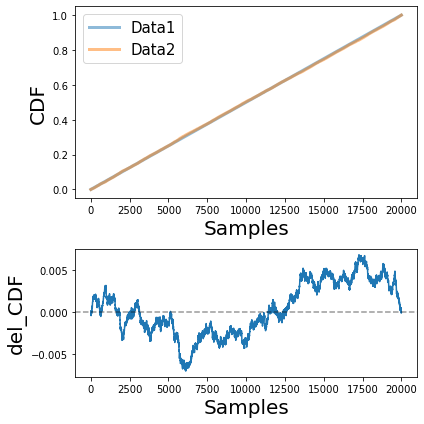

In [4]:
# Test that 'ks_2samp_weights' works for two identical gaussians
# Compare result with that of 'ks_2samp'

N = int(20000)
d1 = np.random.normal(0,1,N)
d2 = np.random.normal(0,1,N)

w1 = None
w2 = None

ks_stats, cdf1, cdf2 = ks_2samp_weights(d1, d2, w1, w2, 
                                        saveplot=False, show=True)

ks_scipy_results = scipy.stats.ks_2samp(d1, d2)
ks_stats_scipy = {'statistic': ks_scipy_results.statistic, 'pvalue': ks_scipy_results.pvalue}

print('Result from original SciPy function:', ks_stats_scipy)
print('Result from new function w/ weights:', ks_stats)

# Test on real data

Now try 'ks_2samp_weights' on real data from an injection-recovery scenario

In [5]:
test = 'test6-s20-b0.48-e0.05-w90'
date = '09Feb22'

trace_S = pd.read_csv('/Users/mason/data/'+date+'/'+test+'/'+test+'_S.csv')
trace_EW = pd.read_csv('/Users/mason/data/'+date+'/'+test+'/'+test+'_EW.csv')
traces = {'S':trace_S, 'EW':trace_EW}

In [6]:
var = 'b'

rhosun = 1.40978
RHO_OBS = (rhosun, 0.1*rhosun)

rho_circ = traces["S"]["rho"]

d2 = traces['EW'][var].values
w2 = None

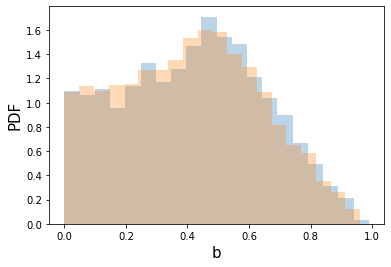

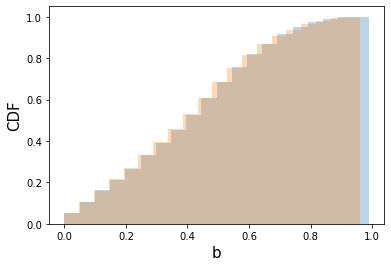

In [7]:
# Apply importance sampling and print the KS statistic (and p-value)
# between the importance sampled 'ecc' from log(T) sampling vs. 'ecc' from e-omega-rho sampling

weights, ecc, omega = imp_sample(rho_circ, RHO_OBS)

traces['S']['ecc'] = ecc
traces['S']['omega'] = omega

d1 = traces['S'][var].values
w1 = weights


fig = plt.figure()
plt.hist(d1, weights=w1, 
         bins=20, alpha=0.3, density=True);
plt.hist(d2, 
         bins=20, alpha=0.3, density=True);
plt.ylabel('PDF', fontsize=15)
plt.xlabel(var, fontsize=15)
plt.show();


fig = plt.figure()
plt.hist(d1, weights=w1, 
         bins=20, alpha=0.3, density=True, cumulative=True);
plt.hist(d2, 
         bins=20, alpha=0.3, density=True, cumulative=True);
plt.ylabel('CDF', fontsize=15)
plt.xlabel(var, fontsize=15)
plt.show();


From the PDF and CDF above, they look like a good match! So what does the KS test show...

{'statistic': 0.02915577380017398, 'pvalue': 8.087888578752741e-08}


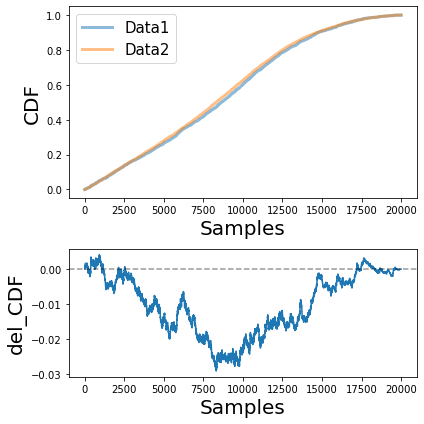

In [8]:
ks_stats, cdf1, cdf2 = ks_2samp_weights(d1, d2, w1, w2, 
                                        saveplot=False, show=True)

print(ks_stats)

Given n_data = 20000, even small deviations between the distributions result in a KS statistic that suggests these are independent, unrelated distributions. Which is not what we were hoping to see!

Since importance sampling involves random draws of {e, omega}, lets run this many times and see what the distribution of p-values is

In [9]:
ks_stat_vals = []
pvals = []

n_runs = 500
n_data = len(traces['EW']['ecc'])
for i in range(n_runs):
    weights, ecc, omega = imp_sample(rho_circ, RHO_OBS)

    traces['S']['ecc'] = ecc
    traces['S']['omega'] = omega

    d1 = traces['S'][var].values
    w1 = weights

    ks_stats, cdf1, cdf2 = ks_2samp_weights(d1, d2, w1, w2, 
                                            saveplot=False, show=False)
    ks_stat_vals.append(ks_stats['statistic'])
    pvals.append(ks_stats['pvalue'])
    

n_runs = 500
n_samples = 20000
Fraction with p-value > 0.05:  6.0%


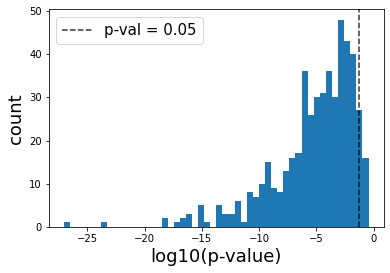

In [10]:
plt.hist(np.log10(pvals), bins=50);
plt.axvline(np.log10(0.05), color='k', ls='--', alpha=0.8, label='p-val = 0.05')
print('n_runs =', n_runs)
print('n_samples =', n_data)
print('Fraction with p-value > 0.05: ', str(round(sum(np.array(pvals)>0.05)/n_runs*100,2))+'%')
plt.xlabel('log10(p-value)', fontsize=18);
plt.ylabel('count', fontsize=18);
plt.legend(fontsize=15);

Only a few percent of these tests have p-values > 0.05, which is concerning...

However, we also noticed that many of the importance sampled weights are small - like, really small:

In [11]:
print('Percent of data with zero weight: %.2f%%'%(round(sum(weights == 0)/n_data*100,2)))

Percent of data with zero weight: 8.26%


Text(0, 0.5, 'count')

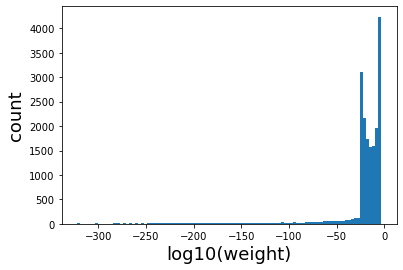

In [12]:
# Now plot histogram of log10 of all non-zero weights
plt.hist(np.log10(weights[weights>0]), bins=100); 
plt.xlabel('log10(weight)', fontsize=18)
plt.ylabel('count', fontsize=18)

That's a lot of small weights!

Let's zoom in on that peak over there...

Text(0, 0.5, 'count')

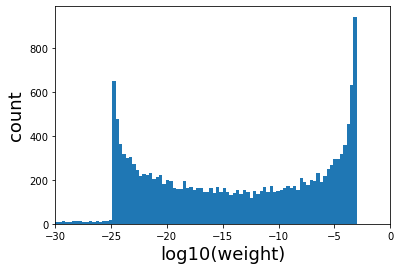

In [13]:
plt.hist(np.log10(weights[weights>0]), bins=100, range=[-30,0]);
plt.xlim(-30,0)
plt.xlabel('log10(weight)', fontsize=18)
plt.ylabel('count', fontsize=18)

Clearly there are a lot of tiny weights, and these may be throwing off our analysis

# Possible solution:
- Give zero weight to anything with initial weight < 1% of the maximum weight
- Throw out all data with zero weight
- Resample a given number ('n_data') of data points (and associated weights) from the importance sampled data
- Resample the same number of data points from the non-weighted data
- Perform a two-sample weighted KS test on these new resampled subsets of data

In [14]:
ks_stat_vals = []
pvals = []
kept_data = []

n_runs = 500
n_data = 1000

for i in range(n_runs):
    
    # This part of importance sampling is the same as 'imp_sample' function
    ecc = np.random.uniform(0., 1., len(rho_circ))
    omega = np.random.uniform(-0.5*np.pi, 1.5*np.pi, len(rho_circ))

    g = (1 + ecc * np.sin(omega)) / np.sqrt(1 - ecc ** 2)
    rho = rho_circ / g ** 3

    log_weight = -0.5 * ((rho - RHO_OBS[0]) / RHO_OBS[1]) ** 2
    weight_rho = np.exp(log_weight - np.max(log_weight))
    weight_rho /= np.sum(weight_rho)

    # Here, we set weights to zero if they are initially < 1% of max weight 
    tol = weight_rho.max()/100
    weight_rho[weight_rho < tol] = 0

    weights = np.array(weight_rho/np.sum(weight_rho))

    # Store 'ecc' and 'omega' in traces['S'] temporarily, 
    # so that any variable can be called by: traces['S'][var]
    traces['S']['ecc'] = ecc
    traces['S']['omega'] = omega

    # Keep only non-zero weighted data
    weights_nonzero = weights>0

    tot = sum(weights_nonzero)
    kept_data.append(tot)

    weights = weights[weights_nonzero]
    trace_S_var = traces['S'][var].values[weights_nonzero]


    # Resample 'n_data' data points from both the importance sampled data and
    # the empirical data from e-omega-rho results ('EW')
    trace_EW_var = traces['EW'][var].values
    idx1 = np.random.choice(range(tot), n_data, replace=False)
    idx2 = np.random.choice(range(len(trace_EW_var)), n_data, replace=False)

    d1 = trace_S_var[idx1]
    d2 = trace_EW_var[idx2]

    w1 = weights[idx1]
    w2 = None

    # Run KS test
    ks_stats, cdf1, cdf2 = ks_2samp_weights(d1, d2, w1, None, 
                                            saveplot=False, show=False)
    ks_stat_vals.append(ks_stats['statistic'])
    pvals.append(ks_stats['pvalue'])

n_runs = 500
n_samples = 1000
Fraction with p-value > 0.05:  86.0%


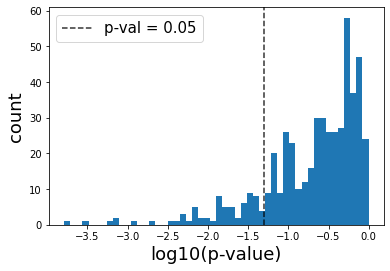

In [15]:
plt.hist(np.log10(pvals), bins=50);
plt.axvline(np.log10(0.05), color='k', ls='--', alpha=0.8, label='p-val = 0.05')
print('n_runs =', n_runs)
print('n_samples =', n_data)
print('Fraction with p-value > 0.05: ', str(round(sum(np.array(pvals)>0.05)/n_runs*100,2))+'%')
plt.xlabel('log10(p-value)', fontsize=18);
plt.ylabel('count', fontsize=18);
plt.legend(fontsize=15);

That looks much more reasonable! ~85% of runs have p-values > 0.05

Now, what if we show this same metric for our identical gaussians test case from earlier...

In [16]:
w1 = None
w2 = None

ks_stat_vals = []
pvals = []

n_runs = 500
n_data = 1000

for i in range(n_runs):
    d1 = np.random.normal(0, 1, n_data)
    d2 = np.random.normal(0, 1, n_data)

    ks_stats, cdf1, cdf2 = ks_2samp_weights(d1, d2, w1, w2, 
                                            saveplot=False, show=False)
    ks_stat_vals.append(ks_stats['statistic'])
    pvals.append(ks_stats['pvalue'])
    

n_runs = 500
n_samples = 1000
Fraction with p-value > 0.05:  95.0%


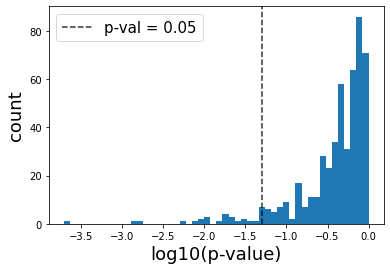

In [17]:
plt.hist(np.log10(pvals), bins=50);
plt.axvline(np.log10(0.05), color='k', ls='--', alpha=0.8, label='p-val = 0.05')
print('n_runs =', n_runs)
print('n_samples =', n_data)
print('Fraction with p-value > 0.05: ', str(round(sum(np.array(pvals)>0.05)/n_runs*100,2))+'%')
plt.xlabel('log10(p-value)', fontsize=18);
plt.ylabel('count', fontsize=18);
plt.legend(fontsize=15);

Alright, so we find that out of 500 runs, p-value > 0.05 for ~95% of runs in our test case vs. ~85% of runs in our example with real data

That seems like good agreement to me! (given that the real data is likely to be less precise than identical gaussians created from the same function)

# New concern?
But this raises a concern regarding how much of the data we have to throw out from our original.

So let's check how much of the data we are actually keeping from the 20000 data points in the weighted sample

Average fraction of data that is kept after throwing out low weights: 0.164


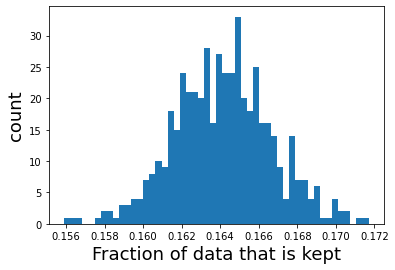

In [18]:
plt.hist(np.array(kept_data)/20000, bins=50);
plt.xlabel('Fraction of data that is kept', fontsize=18);
plt.ylabel('count', fontsize=18);
print('Average fraction of data that is kept after throwing out low weights:', 
      round(np.mean(np.array(kept_data)/20000),3))


So we're only retaining ~16% of the original data, which probably isn't good

However, we are getting the right answer, which is at least reassuring. 

So is there a way we can retain more data but still get the right answer? Or maybe we should use another statistical test?